------- Processing tabnet -------



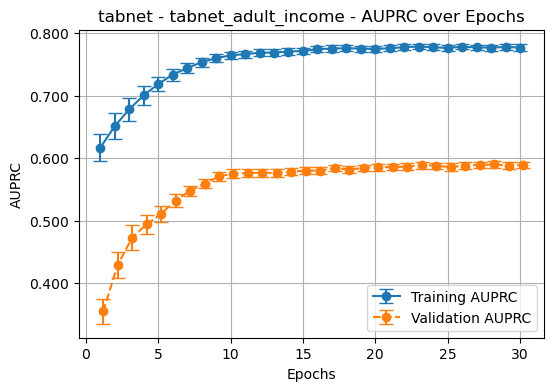

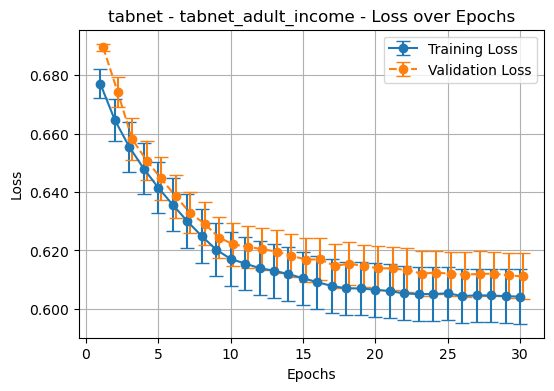

No valid data found in the files.


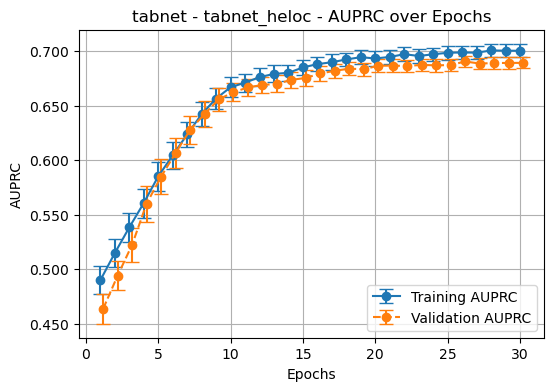

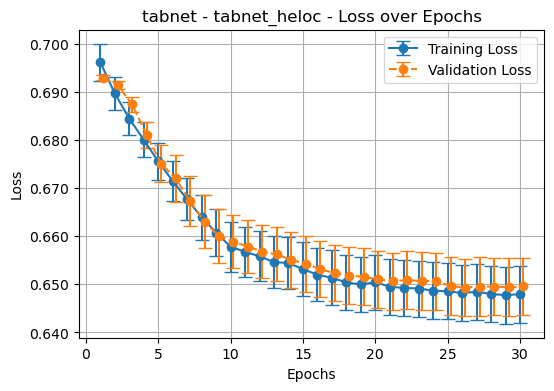

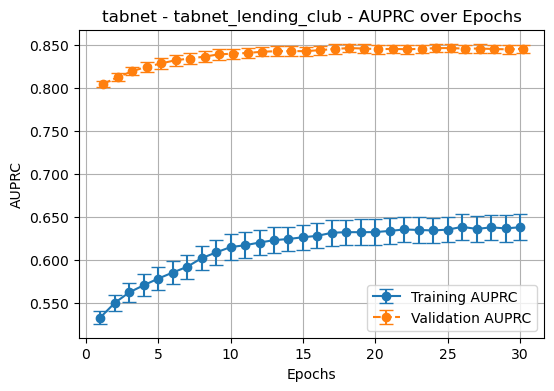

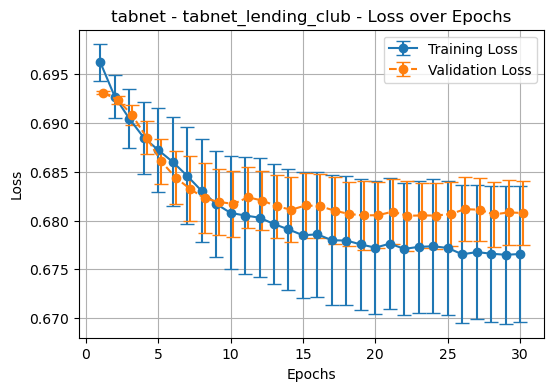

------- Processing node -------



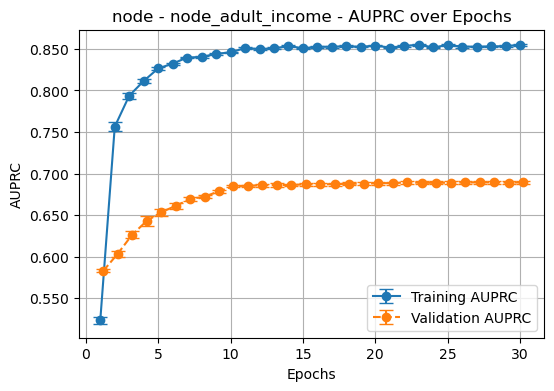

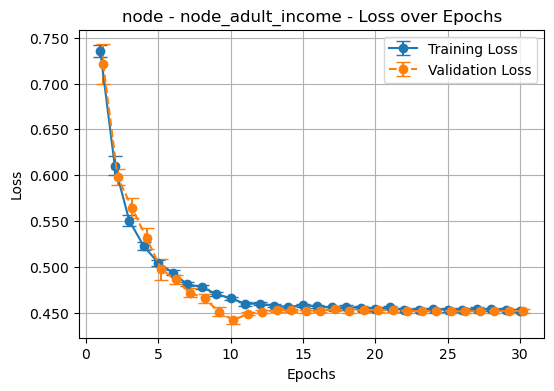

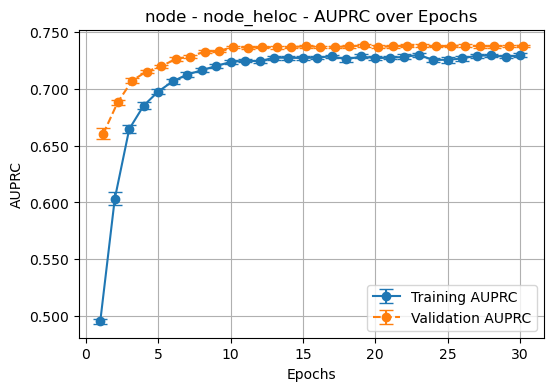

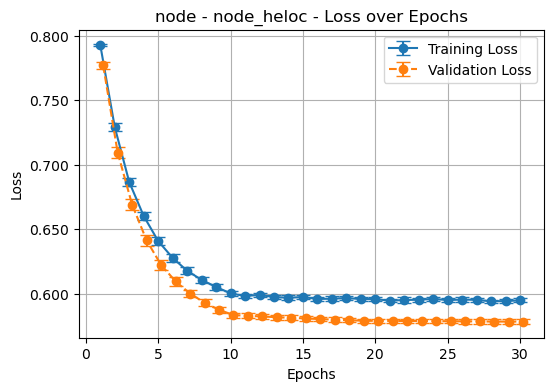

No valid data found in the files.


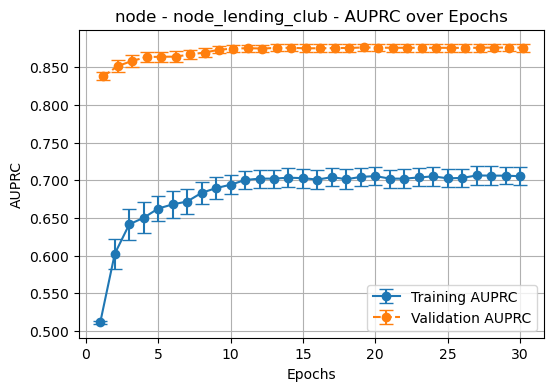

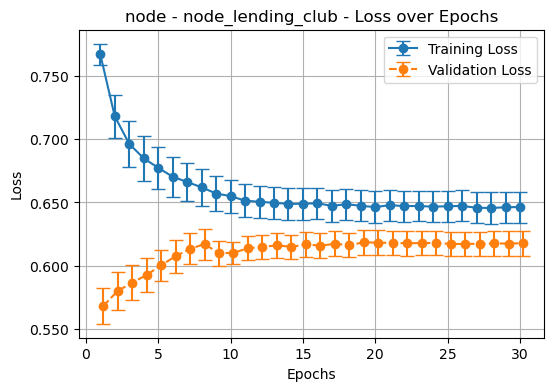

------- Processing xgboost -------



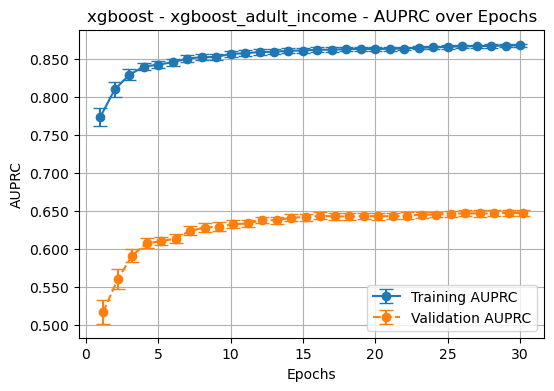

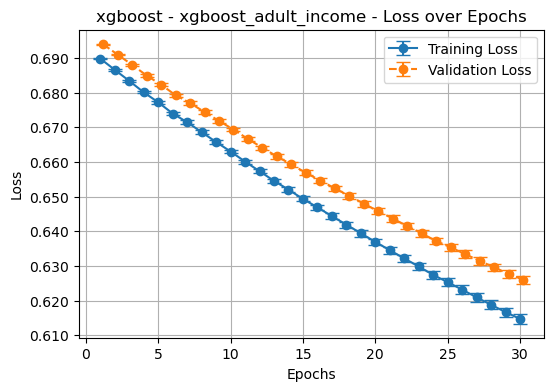

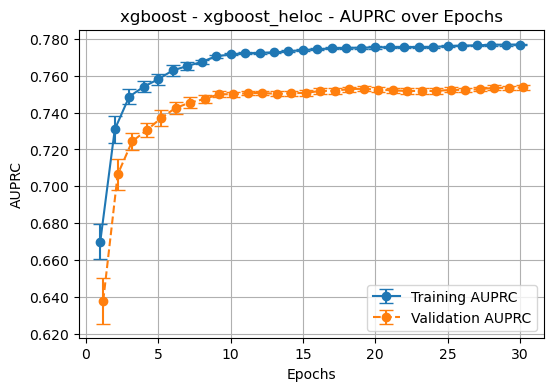

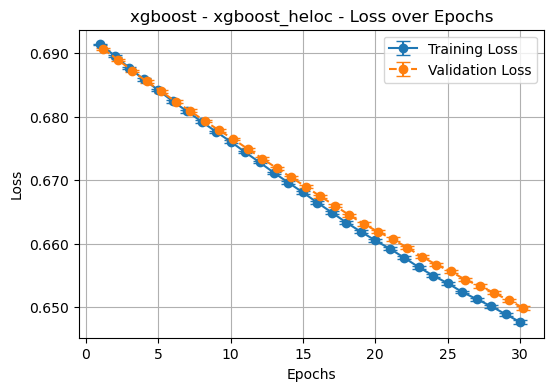

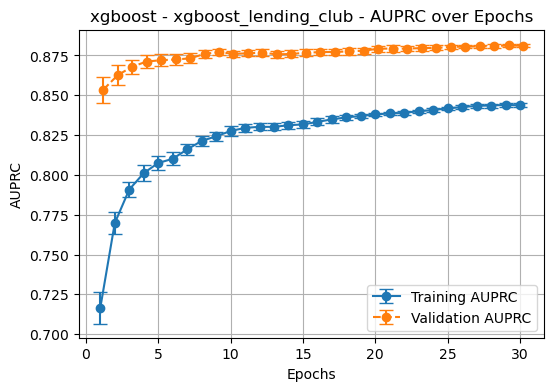

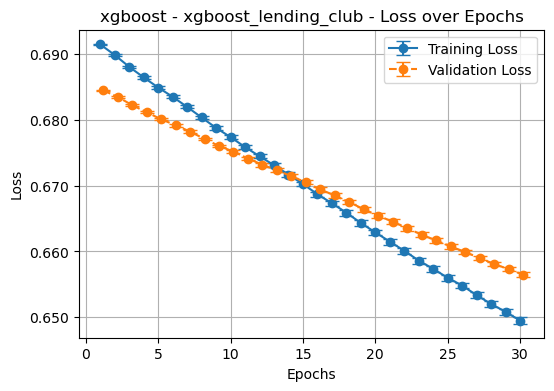

No valid data found in the files.


In [1]:
# -----------------------------------------------------------
# Dissertation Project: An Empirical Study on the Classification 
# Performance of Deep Learning vs. Gradient Boosting 
# on heterogeneous tabular data
#
# This module provides log loss results for all models
#
# Author: Adam Mabrouk
# Supervisor: Ben Ralph
# Institution: University of Bath
# Created on: 01/01/2024
# Version: 1.0
# -----------------------------------------------------------

# Pandas version: 2.0.3
# Python version: 3.11.5

import os
import glob
import pandas as pd
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

main_folder = 'log_loss_and_validation_auprc_results'
base_folders = ['tabnet', 'node', 'xgboost']  

def process_folder(folder_path):
    """
    Load and process data from the specified folder path.
    Calculate mean and standard deviation for metrics across all CSV files,
    limiting the analysis to the first 30 epochs.
    """
    data = {'loss': [], 'val_loss': [], 'auprc': [], 'val_auprc': []}

    if not os.path.isdir(folder_path):
        print("Directory not found:", folder_path)
        return None

    for file_path in glob.glob(os.path.join(folder_path, '*.csv')):
        # Skip any unwanted files
        if file_path.endswith('.DS_Store') or 'ipynb_checkpoints' in file_path:
            continue
        
        df = pd.read_csv(file_path)
        required_columns = ['loss', 'val_loss', 'auprc', 'val_auprc']
        if not all(col in df.columns for col in required_columns):
            print(f"Required columns not found in {file_path}")
            continue

        df = df.head(30)

        for key in data:
            data[key].append(df[key].values)

    if not any(data.values()):
        print("No valid data found in the files.")
        return None

    processed_data = {}
    for key, values in data.items():
        if values:
            stacked_values = np.stack(values, axis=0)
            mean_values = np.mean(stacked_values, axis=0)
            std_values = np.std(stacked_values, axis=0)            
            sem_values = std_values / np.sqrt(stacked_values.shape[0])  
            processed_data[key] = {'mean': mean_values, 'std': std_values, 'sem': sem_values}

    return processed_data

def plot_graphs(metric_data, val_metric_data, title, ylabel, offset=0.2):
    """
    Plot training and validation metrics over epochs with error bars for SEM.
    """
    epochs = range(1, len(metric_data['mean']) + 1)
    epochs_offset = [e + offset for e in epochs]  
    metric_sem = metric_data['sem']
    val_metric_sem = val_metric_data['sem']
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    ax.errorbar(epochs, metric_data['mean'], yerr=metric_sem,
                label='Training ' + ylabel, fmt='-o', capsize=5)
    
    ax.errorbar(epochs_offset, val_metric_data['mean'], yerr=val_metric_sem,
                label='Validation ' + ylabel, fmt='--o', capsize=5)

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)
    plt.show()

def process_base_folder(base_folders, main_folder):
    """
    Process each subfolder within the base folders and generate graphs for results.
    """
    for base_folder in base_folders:
        base_folder_path = os.path.join(main_folder, base_folder)  
        if not os.path.isdir(base_folder_path):
            print(f"Base folder not found: {base_folder_path}")
            continue
        
        print(f'------- Processing {base_folder} -------\n')
        for dataset in os.listdir(base_folder_path):
            dataset_path = os.path.join(base_folder_path, dataset)
            if os.path.isdir(dataset_path):
                folder_results = process_folder(dataset_path)
                if folder_results:

                    plot_graphs(folder_results['auprc'], folder_results['val_auprc'], 
                                f'{base_folder} - {dataset} - AUPRC over Epochs', 'AUPRC')
                    
                    plot_graphs(folder_results['loss'], folder_results['val_loss'], 
                                f'{base_folder} - {dataset} - Loss over Epochs', 'Loss')

process_base_folder(base_folders, main_folder)